In [59]:
import numpy as np
import pandas as pd
import random
import os
working_dir = "/Users/nkarisan/PycharmProjects/BTC_Cell_Line_Atlas_Manuscript"
os.chdir(working_dir)

import BTC_Cell_Line_Atlas_Manuscript.scripts.io_library as io_library
io_library.input_dir = 'input_data/'
io_library.output_dir = 'Figure2/output_fig2/'

from BTC_Cell_Line_Atlas_Manuscript.scripts.io_library import MyLib
from BTC_Cell_Line_Atlas_Manuscript.scripts.clustering_utils import Clustering
from BTC_Cell_Line_Atlas_Manuscript.scripts.visualization import MyVisualization
from BTC_Cell_Line_Atlas_Manuscript.scripts.utils import Utils
from BTC_Cell_Line_Atlas_Manuscript.scripts.differential_dependency import DifferentialDependency

In [60]:
import matplotlib
seed = 2023
random.seed(seed)
np.random.seed(seed)

matplotlib.use("nbagg")


%matplotlib inline
%config InlineBackend.figure_format = "retina"


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
gene_effect_file = 'Main_Data/CRISPR/CRISPR.csv'
gene_effect_df = MyLib.load_csv(gene_effect_file, index_col=0)
gene_effect_df = gene_effect_df.T
gene_effect_df = gene_effect_df.dropna(axis=1)

genes_exclude_file = 'Additional_Data/Selected_Lists/all_common_genes.csv'
genes_exclude = MyLib.load_csv(genes_exclude_file)['Gene'].tolist()
gene_effect_filtered_df = gene_effect_df.loc[:, ~gene_effect_df.columns.isin(genes_exclude)]


upset_file = 'cell_lines_master_upset_2024-4-13.csv'
raw_upset_df = MyLib.load_csv(upset_file)
raw_upset_df.set_index('Cell_line', inplace=True, drop=True)
upset_df = raw_upset_df[raw_upset_df['CRISPR']==1]
upset_df = upset_df[["Subtype"]]

upset_df = upset_df[upset_df['Subtype'] != 'HCC']
gene_effect_filtered_df = gene_effect_filtered_df.loc[upset_df.index]
gene_effect_filtered_df = gene_effect_filtered_df.rename(columns={c:c.split(' (')[0] for c in gene_effect_filtered_df.columns})
gene_effect_filtered_df.shape

input_data/Main_Data/CRISPR/CRISPR.csv  is loaded, shape:  (18443, 60)

input_data/Additional_Data/Selected_Lists/all_common_genes.csv  is loaded, shape:  (2577, 1)

input_data/cell_lines_master_upset_2024-4-13.csv  is loaded, shape:  (87, 11)



(39, 15308)

In [62]:
CNV_file = 'Additional_Data/Selected_Lists/goi_cnv.csv'
cnv_df = MyLib.load_csv(CNV_file)
mut_dir = 'Main_Data/Mutations/subset/'
hotspot_df = MyLib.load_csv(os.path.join(mut_dir, 'Mut_Hot.csv'), index_col=0).T.astype('int64')
dam_df = MyLib.load_csv(os.path.join(mut_dir, 'Mut_Dam.csv'), index_col=0).T.astype('int64')
hotspot_df[hotspot_df > 1] = 1
dam_df[dam_df > 1] = 1
genes = ['ARID1A (8289)', 'PIK3CA (5290)', 'SMAD4 (4089)','KRAS (3845)', 'TP53 (7157)', 'CDKN2A (1029)', 'BRAF (673)', 'PBRM1 (55193)', 'IDH1 (3417)', 'CTNNB1 (1499)']
for gene in genes:
    upset_df = Utils.get_cell_lines_by_hotspot_dam_mutation(gene, hotspot_df, dam_df, upset_df)
    if gene.split(' (')[0] in cnv_df['Gene'].values:
        temp_cnv_df = cnv_df[(cnv_df['Gene'] == gene.split(' (')[0]) & (cnv_df['CN'].isin(['Homo_loss', 'Het_loss']))]
        ids = set(upset_df.index).intersection(temp_cnv_df['Sample_name'].values)
        upset_df.loc[list(ids), gene] = 1
fusion_df = MyLib.load_csv('Main_Data/Fusion/Fusion.csv')
cell_lines = Utils.get_cell_lines_by_fusion(fusion_df, upset_df, 'FGFR2')
upset_df.loc[cell_lines, 'FGFR2'] = 'FUSION'
upset_df['FGFR2'] = upset_df['FGFR2'].fillna(0)
upset_df['FGFR2'] = upset_df['FGFR2'].replace('FUSION', 1)
upset_df.loc['ICC10-8', 'FGFR2'] = 0 # We do not consider ICC10-8 for this analysis refer to the manuscript

input_data/Additional_Data/Selected_Lists/goi_cnv.csv  is loaded, shape:  (74, 4)

input_data/Main_Data/Mutations/subset/Mut_Hot.csv  is loaded, shape:  (467, 71)

input_data/Main_Data/Mutations/subset/Mut_Dam.csv  is loaded, shape:  (17390, 71)

input_data/Main_Data/Fusion/Fusion.csv  is loaded, shape:  (1231, 69)



In [63]:
MyLib.save_csv(upset_df, 'upset_differential_dependencies.csv')


File  Figure2/output_fig2/upset_differential_dependencies.csv saved, shape: (39, 12)


# Differential Dependency

## Filtration steps

In [64]:
var_df = Clustering.select_top_variable_features(gene_effect_filtered_df, top_k=100)
var_df.shape

(39, 100)

In [65]:
lrt_file = 'Additional_Data/Selected_Lists/lrt_table.csv'
lrt_df = MyLib.load_csv(lrt_file)
lrt_df = lrt_df[lrt_df['skewed_left']]
lrt_df.reset_index(inplace=True, drop=True)
lrt_df['gene'] = lrt_df['gene'].apply(lambda x:x.split('..')[0]+' ('+x.split('..')[1]+')').apply(lambda x:x.replace('.)', ')'))
lrt_df['gene'] = lrt_df['gene'].apply(lambda x:x.replace('.', '-'))
lrt_df['name'] = lrt_df['gene'].apply(lambda x:x.split()[0])
threshold = np.percentile(lrt_df['lrt'].dropna(), 50)
genes_lrt_l = [g for g in lrt_df[lrt_df['lrt']> round(threshold)]['gene'].tolist() if g in gene_effect_df.columns]

gene_effect_lrt_df = gene_effect_df[genes_lrt_l]

genes_lrt_l = [g for g in lrt_df[lrt_df['lrt']> round(threshold)]['name'].tolist() if g in gene_effect_filtered_df.columns]
gene_effect_lrt_renamed_df = gene_effect_filtered_df[genes_lrt_l]
gene_effect_lrt_renamed_df.shape

input_data/Additional_Data/Selected_Lists/lrt_table.csv  is loaded, shape:  (18443, 5)



(39, 4907)

In [66]:
cosmic_file = 'Additional_Data/Selected_Lists/cosmic/Census_allFri Dec 22 20_09_34 2023.csv'
cosmic_df = MyLib.load_csv(cosmic_file, index_col=0)

cosmic_df = cosmic_df[cosmic_df['Hallmark'] == 'Yes']
hallmark_l = cosmic_df.index.tolist()
hallmark_l = sorted(set(hallmark_l).intersection(gene_effect_filtered_df.columns.tolist()))
len(hallmark_l)

input_data/Additional_Data/Selected_Lists/cosmic/Census_allFri Dec 22 20_09_34 2023.csv  is loaded, shape:  (743, 19)



291

(291,)


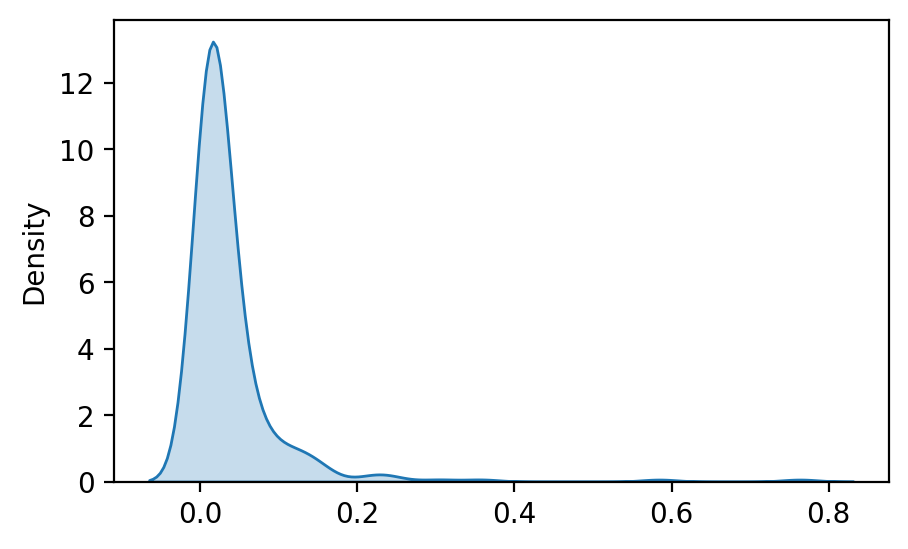

In [67]:
var_sr = gene_effect_filtered_df[hallmark_l].var(axis=0)
print(var_sr.shape)
MyVisualization.plot_distribution(var_sr)

In [68]:
hm_df = Clustering.drop_low_vars(gene_effect_filtered_df[hallmark_l], threshold=0.1)
hm_df.shape

(39, 24)

In [69]:
pref_file = 'Additional_Data/Selected_Lists/BTC_Preferential Dependencies.csv'
pref_l = MyLib.load_csv(pref_file, index_col=0).index.tolist()
pref_l = [g for g in pref_l if g in gene_effect_filtered_df.columns]
len(pref_l)

input_data/Additional_Data/Selected_Lists/BTC_Preferential Dependencies.csv  is loaded, shape:  (696, 1)



620

In [70]:
genes_l = sorted(set(var_df.columns).union(hm_df.columns).union(set(gene_effect_lrt_renamed_df.columns)).union(pref_l)) 
gene_effect_filtered_df2 = gene_effect_filtered_df[genes_l]

gene_effect_filtered_df2.shape

(39, 5018)

### KRAS

In [71]:
gene = 'KRAS (3845)'
res_df = DifferentialDependency.differential_dependency(gene_effect_filtered_df2, upset_df, test='ttest', group=gene)

KRAS (3845)
Number of processes: 10 -------------------------------

File  Figure2/output_fig2/KRAS (3845)_all_features_stats.csv saved, shape: (5018, 6)


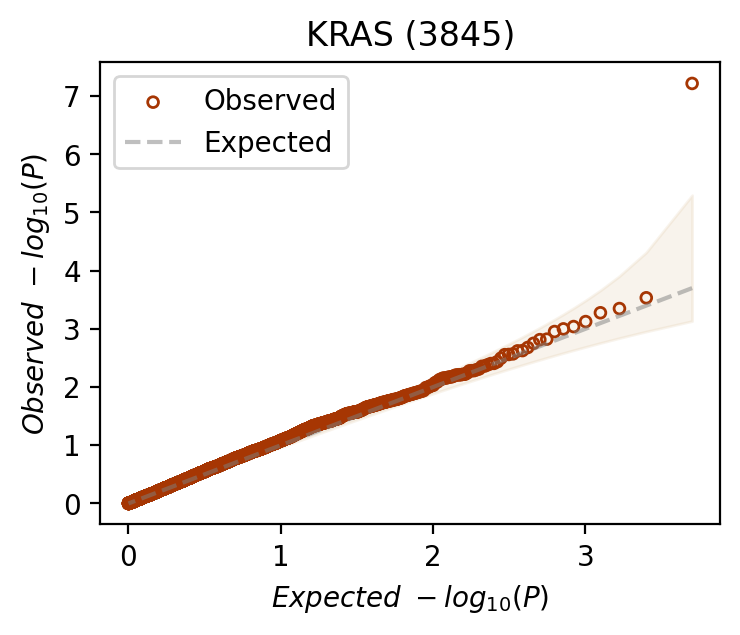

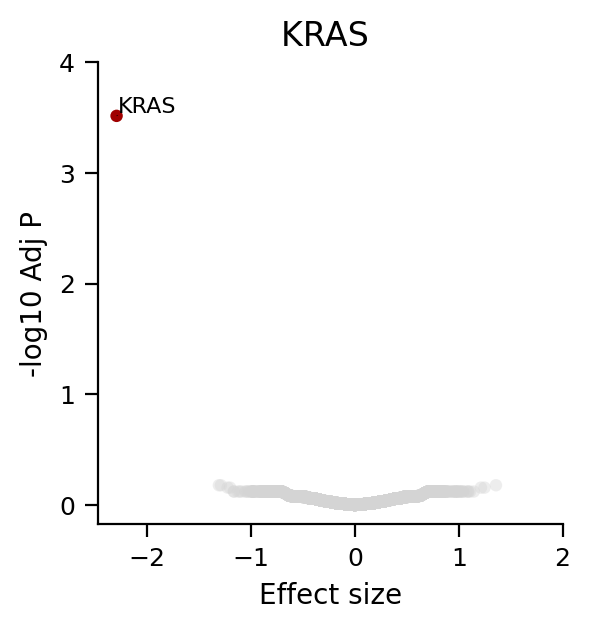


File  Figure2/output_fig2/KRAS (3845)_features_Down_.csv saved, shape: (1, 5)


In [72]:
DifferentialDependency.select_differential_dependency(res_df, gene, in_group_col='in_group_gene_effect_mean',  ylim_top=4, xtick_step=1, ytick_step=1, xlim_right=2, title='', save_figure=True)

### CTNNB1

In [73]:
gene = 'CTNNB1 (1499)'
res_df = DifferentialDependency.differential_dependency(gene_effect_filtered_df2, upset_df, test='ttest', group=gene)

CTNNB1 (1499)
Number of processes: 10 -------------------------------

File  Figure2/output_fig2/CTNNB1 (1499)_all_features_stats.csv saved, shape: (5018, 6)


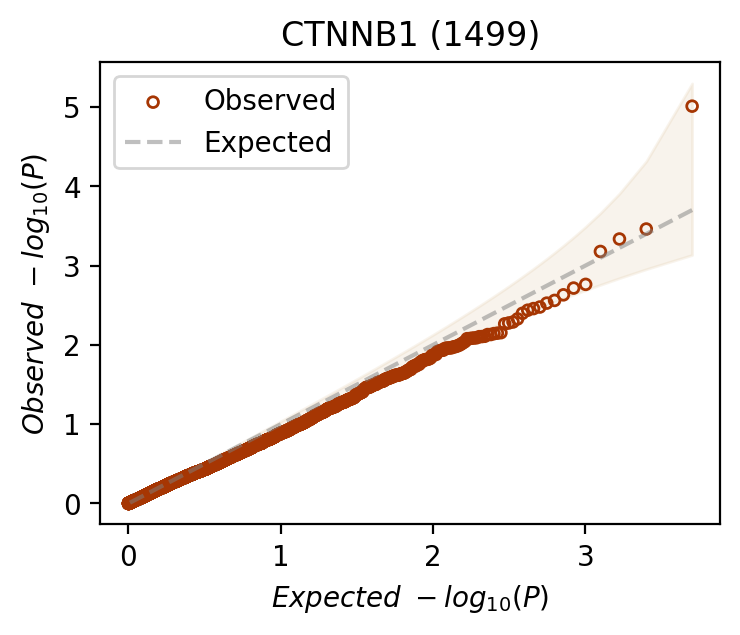

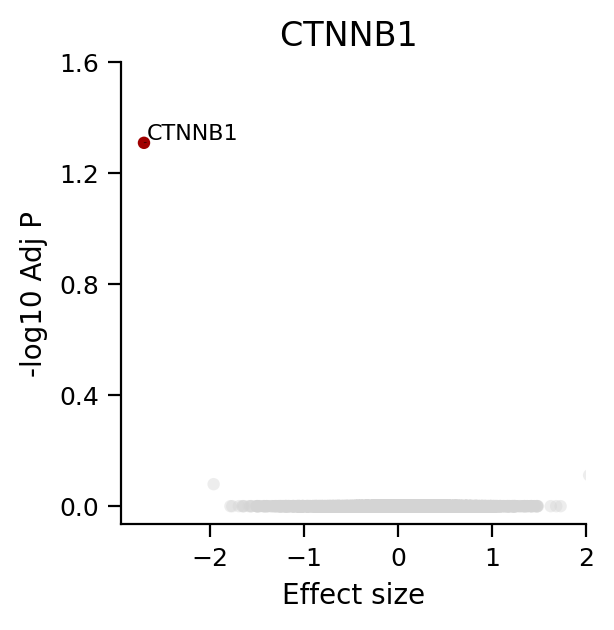


File  Figure2/output_fig2/CTNNB1 (1499)_features_Down_.csv saved, shape: (1, 5)


In [74]:
DifferentialDependency.select_differential_dependency(res_df, gene,  in_group_col='in_group_gene_effect_mean', ylim_top=1.6, ytick_step=.4, xtick_step=1, xlim_right=2,  title='',  save_figure=True)

### BRAF

In [75]:
gene = 'BRAF (673)'
res_df = DifferentialDependency.differential_dependency(gene_effect_filtered_df2, upset_df, test='ttest', group=gene)

BRAF (673)
Number of processes: 10 -------------------------------

File  Figure2/output_fig2/BRAF (673)_all_features_stats.csv saved, shape: (5018, 6)


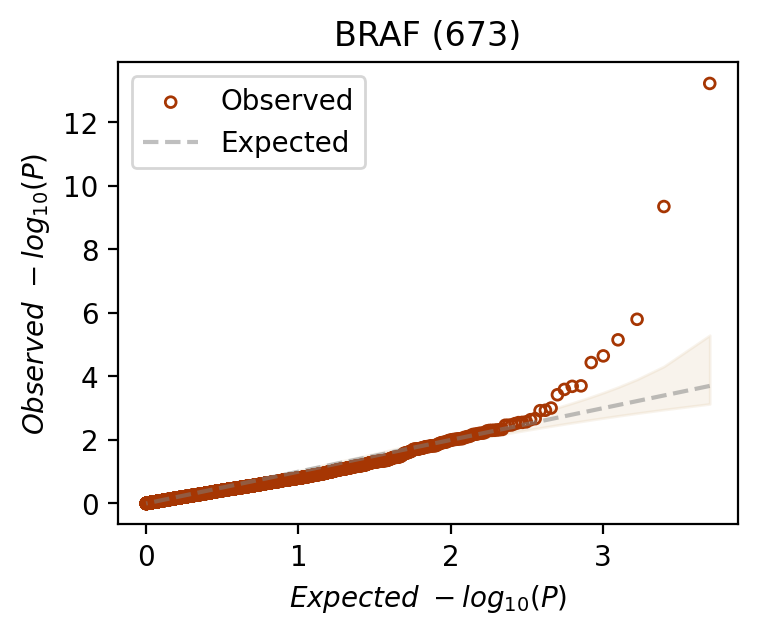

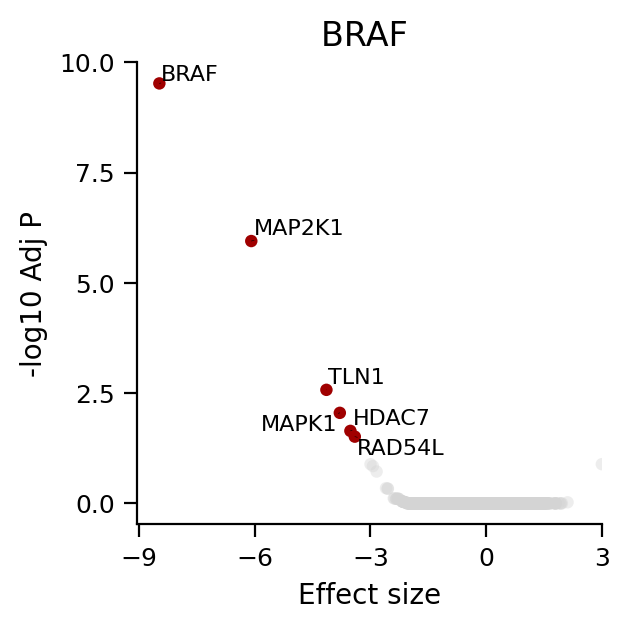


File  Figure2/output_fig2/BRAF (673)_features_Down_.csv saved, shape: (6, 5)


In [76]:
DifferentialDependency.select_differential_dependency(res_df, gene,  in_group_col='in_group_gene_effect_mean',  ylim_top=10, ytick_step=2.5, xtick_step=3, xlim_right=3,  title='',  save_figure=True)

### FGFR2

In [77]:
gene = 'FGFR2'
res_df = DifferentialDependency.differential_dependency(gene_effect_filtered_df2, upset_df, test='ttest', group=gene)

FGFR2
Number of processes: 10 -------------------------------

File  Figure2/output_fig2/FGFR2_all_features_stats.csv saved, shape: (5018, 6)


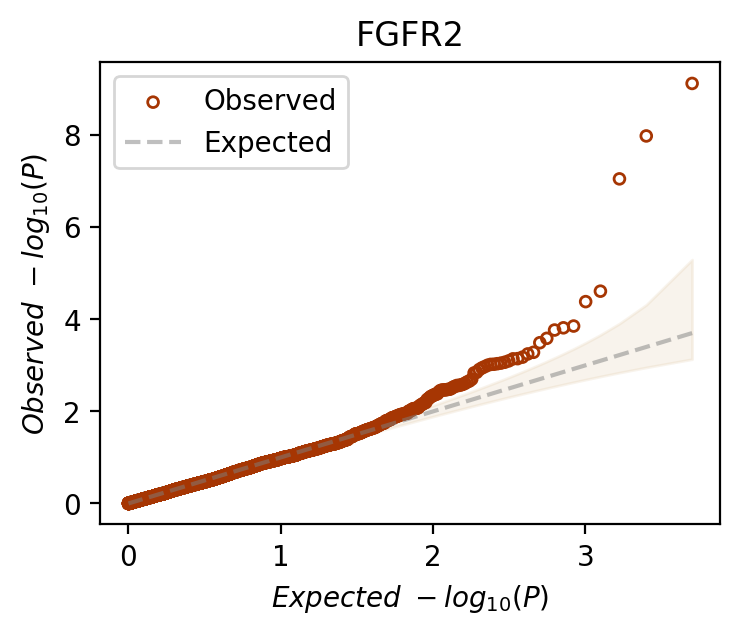

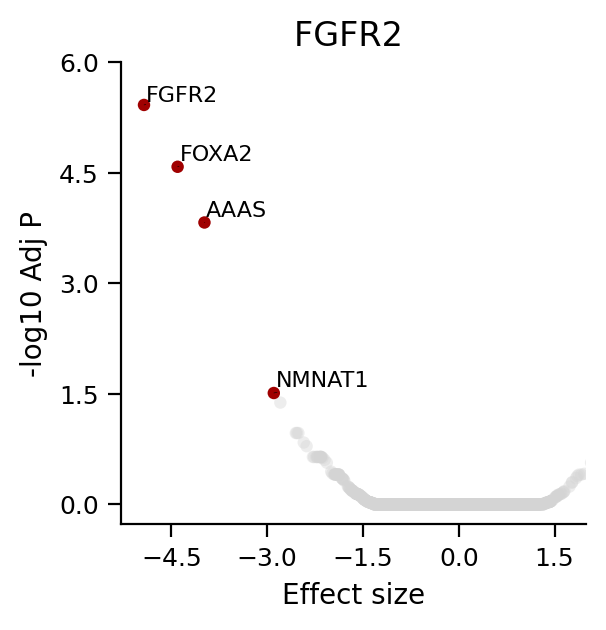


File  Figure2/output_fig2/FGFR2_features_Down_.csv saved, shape: (4, 5)


In [78]:
DifferentialDependency.select_differential_dependency(res_df, gene, in_group_col='in_group_gene_effect_mean', ylim_top=6, ytick_step=1.5, xtick_step=1.5, xlim_right=2.,  title='',  force_text=1.3, save_figure=True)

### IDH1

In [79]:
gene = 'IDH1 (3417)'
res_df = DifferentialDependency.differential_dependency(gene_effect_filtered_df2, upset_df, test='ttest', group=gene)

IDH1 (3417)
Number of processes: 10 -------------------------------

File  Figure2/output_fig2/IDH1 (3417)_all_features_stats.csv saved, shape: (5018, 6)


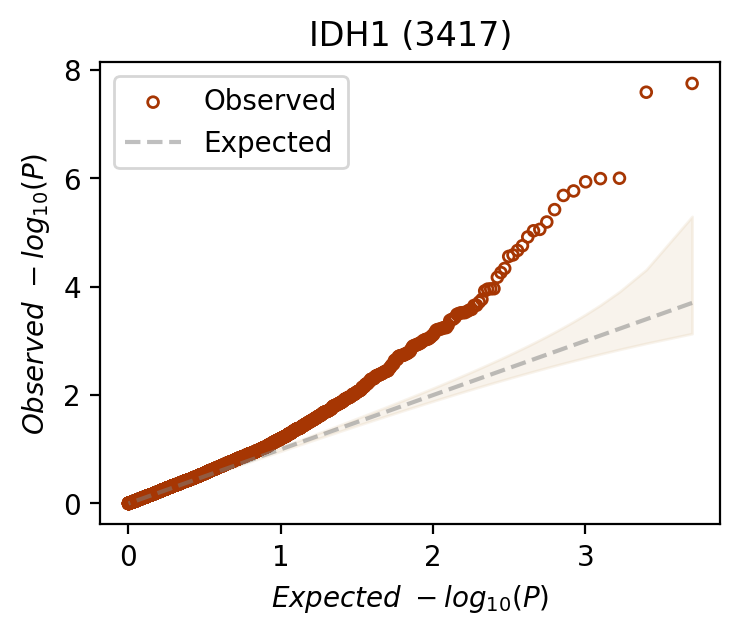

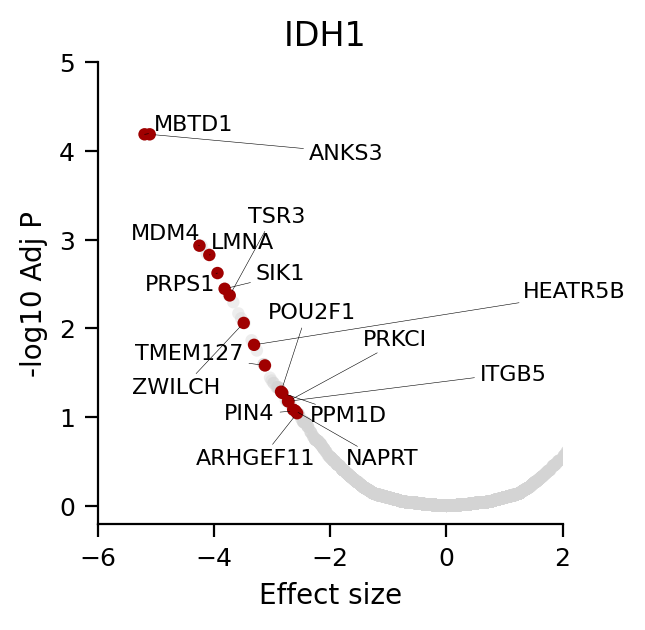


File  Figure2/output_fig2/IDH1 (3417)_features_Down_.csv saved, shape: (17, 5)


In [80]:
DifferentialDependency.select_differential_dependency(res_df, gene, in_group_col='in_group_gene_effect_mean', ylim_top=5, ytick_step=1, xtick_step=2, xlim_right=2, xlim_left=-6, force_points=1, force_text=1.8,  top_labels_cutoff=0, cut_off_texts=20,  title='', save_figure=True)

### PBRM1

In [81]:
gene =  'PBRM1 (55193)'
res_df = DifferentialDependency.differential_dependency(gene_effect_filtered_df2, upset_df, test='ttest', group=gene)

PBRM1 (55193)
Number of processes: 10 -------------------------------

File  Figure2/output_fig2/PBRM1 (55193)_all_features_stats.csv saved, shape: (5018, 6)


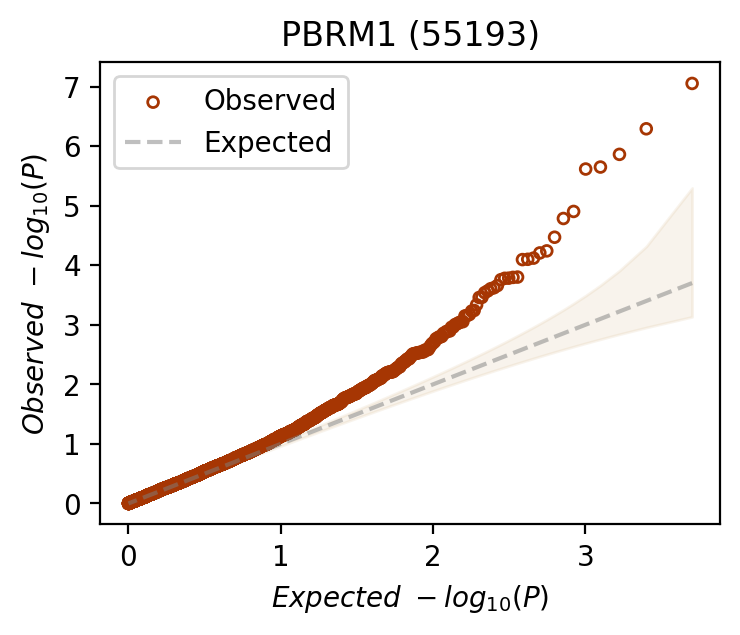

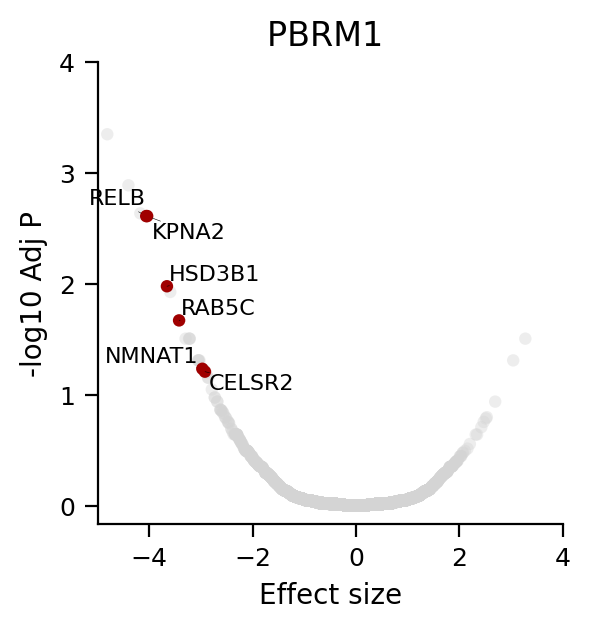


File  Figure2/output_fig2/PBRM1 (55193)_features_Down_.csv saved, shape: (6, 5)


In [82]:
DifferentialDependency.select_differential_dependency(res_df, gene, in_group_col='in_group_gene_effect_mean', ylim_top=4, ytick_step=1, xtick_step=2, xlim_right=4, xlim_left=-5, top_labels_cutoff=0,title='', save_figure=True)

### TP53

In [83]:
gene = 'TP53 (7157)'
res_df = DifferentialDependency.differential_dependency(gene_effect_filtered_df2, upset_df, test='ttest', group=gene)

TP53 (7157)
Number of processes: 10 -------------------------------

File  Figure2/output_fig2/TP53 (7157)_all_features_stats.csv saved, shape: (5018, 6)


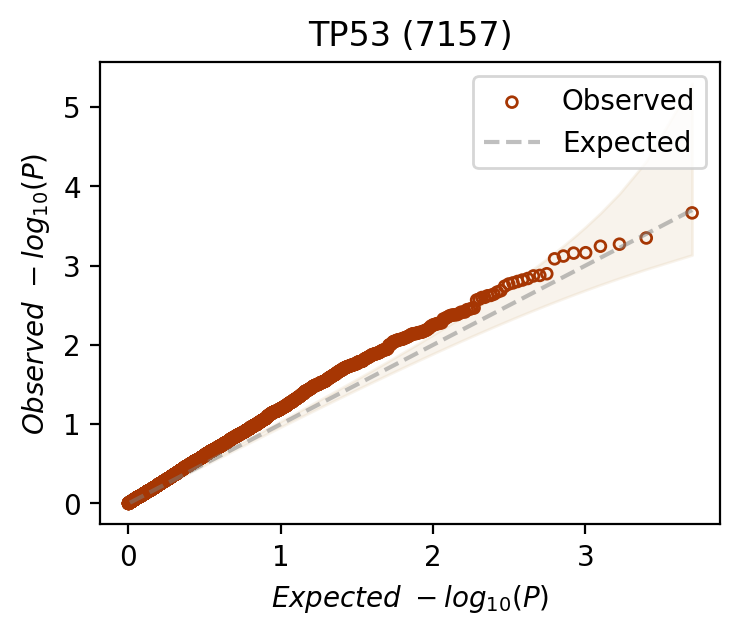

In [84]:
DifferentialDependency.select_differential_dependency(res_df, gene, in_group_col='in_group_gene_effect_mean', ylim_top=4, ytick_step=1, xtick_step=2, xlim_right=4, xlim_left=-5, top_labels_cutoff=0,title='', save_figure=True)

### ARID1A

In [85]:
gene = 'ARID1A (8289)'
res_df = DifferentialDependency.differential_dependency(gene_effect_filtered_df2, upset_df, test='ttest', group=gene)

ARID1A (8289)
Number of processes: 10 -------------------------------

File  Figure2/output_fig2/ARID1A (8289)_all_features_stats.csv saved, shape: (5018, 6)


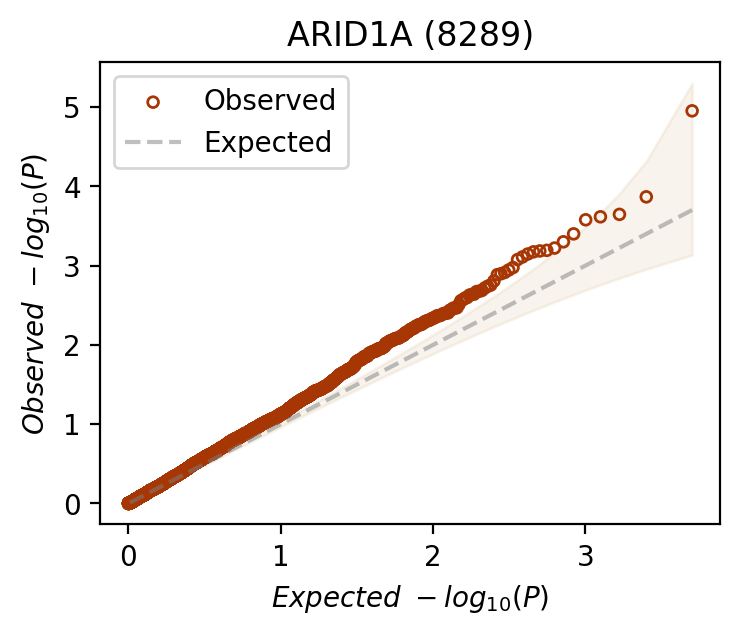

In [86]:
DifferentialDependency.select_differential_dependency(res_df, gene, in_group_col='in_group_gene_effect_mean', ylim_top=4, ytick_step=1, xtick_step=2, xlim_right=4, xlim_left=-5, top_labels_cutoff=0,title='', save_figure=True)

### SMAD4

In [87]:
gene = 'SMAD4 (4089)'
res_df = DifferentialDependency.differential_dependency(gene_effect_filtered_df2, upset_df, test='ttest', group=gene)

SMAD4 (4089)
Number of processes: 10 -------------------------------

File  Figure2/output_fig2/SMAD4 (4089)_all_features_stats.csv saved, shape: (5018, 6)


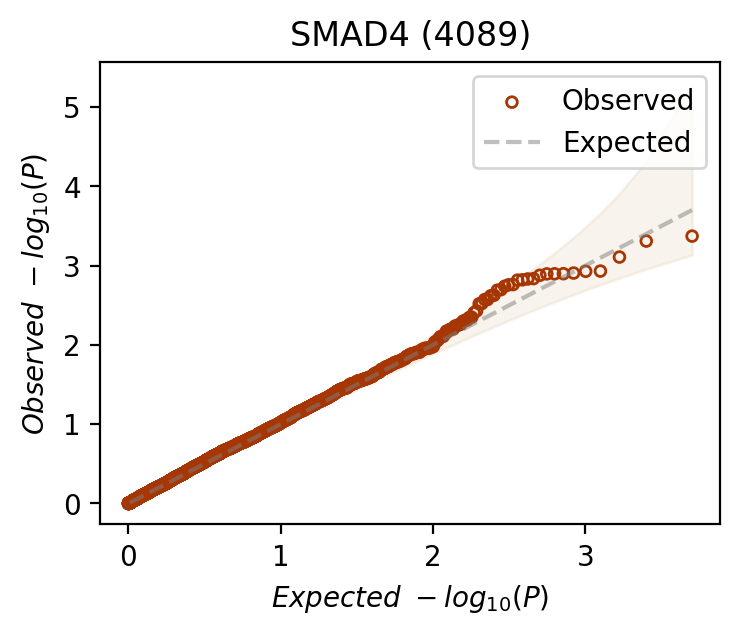

In [88]:
DifferentialDependency.select_differential_dependency(res_df, gene, in_group_col='in_group_gene_effect_mean', ylim_top=4, ytick_step=1, xtick_step=2, xlim_right=4, xlim_left=-5, top_labels_cutoff=0,title='', save_figure=True)

# Dot plot of top features

In [89]:
gene_effect_df = gene_effect_df.rename(columns={c:c.split(' (')[0] for c in gene_effect_df.columns})

In [90]:
genes_dependencies = ['BRAF', 'MAPK1', 'CBLL1','MAP2K1',  'HDAC7', 'NMNAT1', 'AAAS', 'HNF1B', 'ITGB5',  'MBTD1',  'PRKCI', 'TNS3', 'PARD3'] # x-axis order
genes_mutated = {
                'IDH1 (3417)':['MBTD1', 'PARD3', 'PRKCI', 'HNF1B', 'TNS3', 'ITGB5'],
                'PBRM1 (55193)':['NMNAT1'],
                'FGFR2':['AAAS', 'NMNAT1'],#'FOXA2', 'FGFR2', 
                'BRAF (673)':['BRAF', 'MAPK1', 'MAP2K1', 'CBLL1', 'HDAC7']
                 }

In [91]:
df = pd.DataFrame(index=list(genes_mutated.keys()), columns=genes_dependencies)
size_df = pd.DataFrame(index=list(genes_mutated.keys()), columns=genes_dependencies)
for gene in genes_mutated:
    mt_df = upset_df[upset_df[gene] == 1]
    for feat_gene in genes_dependencies:
        temp_gene_effect_sr = gene_effect_df.loc[mt_df.index, feat_gene]
        less_than_minus_0_5 = np.sum(temp_gene_effect_sr <= -0.5)
        size_df.loc[gene, feat_gene] = less_than_minus_0_5 / len(temp_gene_effect_sr)
        df.loc[gene, feat_gene] = temp_gene_effect_sr.mean()
df.index = df.index.map(lambda x:x.split(' (')[0])
size_df.index = size_df.index.map(lambda x:x.split(' (')[0])

In [92]:
y = ['IDH1', 'PBRM1', 'FGFR2', 'BRAF']
filtered_df = pd.DataFrame(0, index=y, columns=genes_dependencies)
size_filtered_df = pd.DataFrame(0, index=y, columns=genes_dependencies)
for stripped, gene in zip(y, genes_mutated):
    filtered_df.loc[stripped, genes_mutated[gene]] = df.loc[stripped, genes_mutated[gene]]
    size_filtered_df.loc[stripped, genes_mutated[gene]] = size_df.loc[stripped, genes_mutated[gene]]

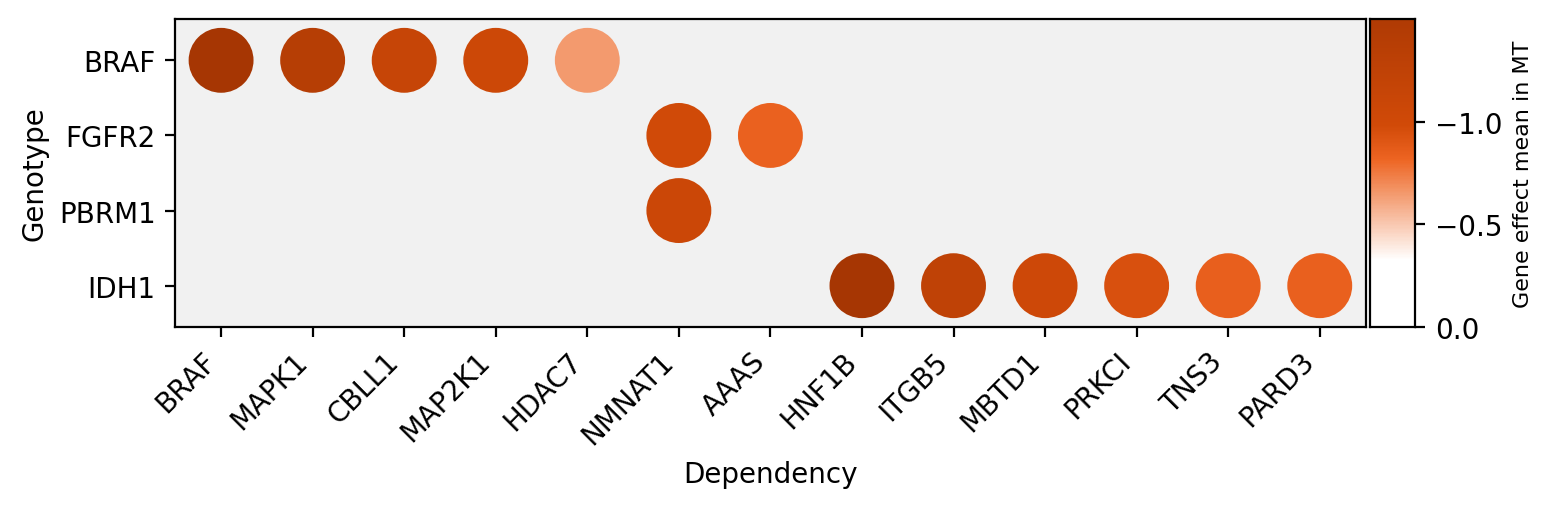

In [93]:
MyVisualization.dot_plot(filtered_df.T, size_df=size_filtered_df.T,
    size_range=[0,1],
    legend_num=None,
    marker='o',
    y_order=list(df.index),
    x_order=list(df.columns),
    ylabel='Genotype',
    xlabel='Dependency', file_name='top_genotype_hits')

# IDH Genotype in DepMap

In [94]:
ccle_cripsr_file = 'Additional_Data/DepMap/CRISPRGeneEffect_internal-23q2-1e49_v97_filtered_by_public_ids.csv'
ccle_crispr_df = MyLib.load_csv(ccle_cripsr_file, index_col=0)
ccle_crispr_df = ccle_crispr_df.dropna(axis=1)
ccle_crispr_df = ccle_crispr_df.rename(columns={c:c.split(' (')[0] for c in ccle_crispr_df.columns})
print(f'ccle_crispr_df shape:{ccle_crispr_df.shape}')

input_data/Additional_Data/DepMap/CRISPRGeneEffect_internal-23q2-1e49_v97_filtered_by_public_ids.csv  is loaded, shape:  (1100, 18443)

ccle_crispr_df shape:(1100, 17107)


In [95]:
ccle_hotsop_file = 'Additional_Data/DepMap/OmicsSomaticMutationsMatrixHotspot_internal-23q2-1e49_v97_filtered_by_public_ids.csv'
ccle_mut_hot_df = MyLib.load_csv(ccle_hotsop_file, index_col=0)

ccle_dam_file = 'Additional_Data/DepMap/OmicsSomaticMutationsMatrixDamaging_internal-23q2-1e49_v97_filtered_by_public_ids.csv'
ccle_mut_dam_df = MyLib.load_csv(ccle_dam_file, index_col=0)
ccle_mut_hot_df = ccle_mut_hot_df.astype(int).replace(2,1)
ccle_mut_dam_df = ccle_mut_dam_df.astype(int).replace(2,1)

input_data/Additional_Data/DepMap/OmicsSomaticMutationsMatrixHotspot_internal-23q2-1e49_v97_filtered_by_public_ids.csv  is loaded, shape:  (2015, 467)

input_data/Additional_Data/DepMap/OmicsSomaticMutationsMatrixDamaging_internal-23q2-1e49_v97_filtered_by_public_ids.csv  is loaded, shape:  (2015, 17390)



In [96]:
gene = 'IDH1 (3417)'
ccle_mut_df= ccle_mut_dam_df.loc[:, [gene]] | ccle_mut_hot_df.loc[:, [gene]]
ccle_other_mt = ccle_mut_df[ccle_mut_df[gene]==1]
ccle_other_mt

,IDH1 (3417)
ACH-002806,1
ACH-000990,1
ACH-001143,1
ACH-000054,1
ACH-001380,1
ACH-000978,1
ACH-000950,1
ACH-002094,1
ACH-000657,1
ACH-002093,1


Keep the four real IDH1 mutant cell lines

In [97]:
mut_ids = ['ACH-000161', 'ACH-001380', 'ACH-000209', 'ACH-001856']
ccle_other_mt = ccle_other_mt.drop(mut_ids, axis=0).copy()
ccle_other_mt.shape

(12, 1)

Remove other IDH1 mutant cell lines from CRISPR data

In [98]:
ids = set(ccle_other_mt.index).intersection(ccle_crispr_df.index)
ccle_crispr_filtered_df = ccle_crispr_df.drop(ids, axis=0)
ccle_crispr_filtered_df.shape

(1094, 17107)

In [99]:
ccle_upset_df = pd.DataFrame(0, index=ccle_crispr_filtered_df.index, columns=['IDH1'])
ccle_upset_df.loc[mut_ids, 'IDH1'] = 1

## Filtration steps

In [100]:
var_df = Clustering.select_top_variable_features(ccle_crispr_filtered_df, top_k=100)
var_df.shape

(1094, 100)

In [101]:
lrt_file = 'Additional_Data/Selected_Lists/lrt_table.csv'
lrt_df = MyLib.load_csv(lrt_file)
lrt_df = lrt_df[lrt_df['skewed_left']]
lrt_df.reset_index(inplace=True, drop=True)
lrt_df['gene'] = lrt_df['gene'].apply(lambda x:x.split('..')[0]+' ('+x.split('..')[1]+')').apply(lambda x:x.replace('.)', ')'))
lrt_df['gene'] = lrt_df['gene'].apply(lambda x:x.replace('.', '-'))
lrt_df['name'] = lrt_df['gene'].apply(lambda x:x.split()[0])
threshold = np.percentile(lrt_df['lrt'].dropna(), 50)
# genes_lrt_l = [g for g in lrt_df[lrt_df['lrt']> round(threshold)]['gene'].tolist() if g in ccle_crispr_filtered_df.columns]
# 
# ccle_gene_effect_lrt_df = ccle_crispr_filtered_df[genes_lrt_l]

genes_lrt_l = [g for g in lrt_df[lrt_df['lrt']> round(threshold)]['name'].tolist() if g in ccle_crispr_filtered_df.columns]
ccle_gene_effect_lrt_df = ccle_crispr_filtered_df[genes_lrt_l]
ccle_gene_effect_lrt_df.shape

input_data/Additional_Data/Selected_Lists/lrt_table.csv  is loaded, shape:  (18443, 5)



(1094, 5444)

In [102]:
cosmic_file = 'Additional_Data/Selected_Lists/cosmic/Census_allFri Dec 22 20_09_34 2023.csv'
cosmic_df = MyLib.load_csv(cosmic_file, index_col=0)

cosmic_df = cosmic_df[cosmic_df['Hallmark'] == 'Yes']
hallmark_l = cosmic_df.index.tolist()
hallmark_l = sorted(set(hallmark_l).intersection(ccle_crispr_filtered_df.columns.tolist()))
len(hallmark_l)

input_data/Additional_Data/Selected_Lists/cosmic/Census_allFri Dec 22 20_09_34 2023.csv  is loaded, shape:  (743, 19)



345

(345,)


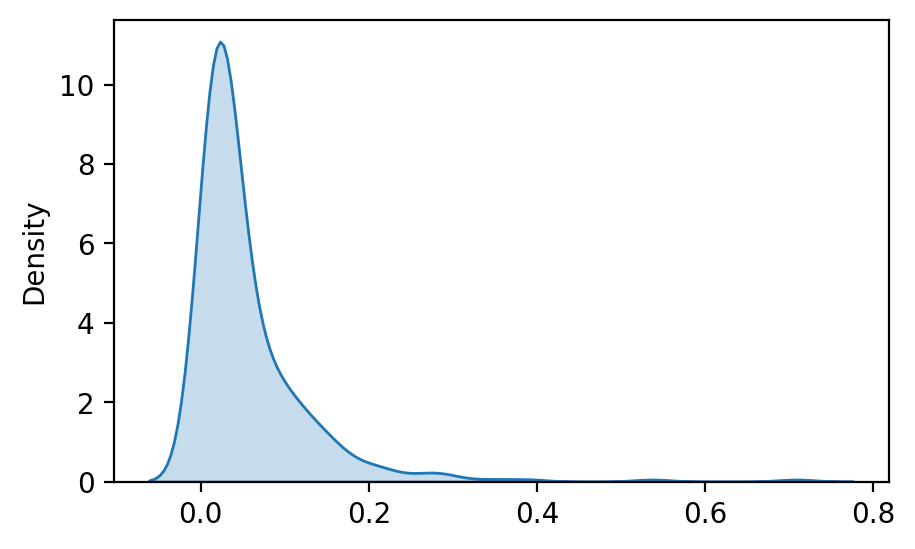

In [103]:
var_sr = ccle_crispr_filtered_df[hallmark_l].var(axis=0)
print(var_sr.shape)
MyVisualization.plot_distribution(var_sr)

In [104]:
hm_df = Clustering.drop_low_vars(ccle_crispr_filtered_df[hallmark_l], threshold=0.1)
hm_df.shape

(1094, 57)

In [105]:
pref_file = 'Additional_Data/Selected_Lists/BTC_Preferential Dependencies.csv'
pref_l = MyLib.load_csv(pref_file, index_col=0).index.tolist()
pref_l = [g for g in pref_l if g in ccle_crispr_filtered_df.columns]
len(pref_l)

input_data/Additional_Data/Selected_Lists/BTC_Preferential Dependencies.csv  is loaded, shape:  (696, 1)



696

In [106]:
genes_l = sorted(set(var_df.columns).union(hm_df.columns).union(set(ccle_gene_effect_lrt_df.columns)).union(pref_l)) 
ccle_crispr_filtered_df2 = ccle_crispr_filtered_df[genes_l]

ccle_crispr_filtered_df2.shape

(1094, 5639)

## IDH1 

In [107]:
gene = 'IDH1'
res_df = DifferentialDependency.differential_dependency(ccle_crispr_filtered_df2, ccle_upset_df, test='ttest', group=gene, filename='DepMap')

IDH1
Number of processes: 10 -------------------------------

File  Figure2/output_fig2/IDH1_DepMapall_features_stats.csv saved, shape: (5639, 6)


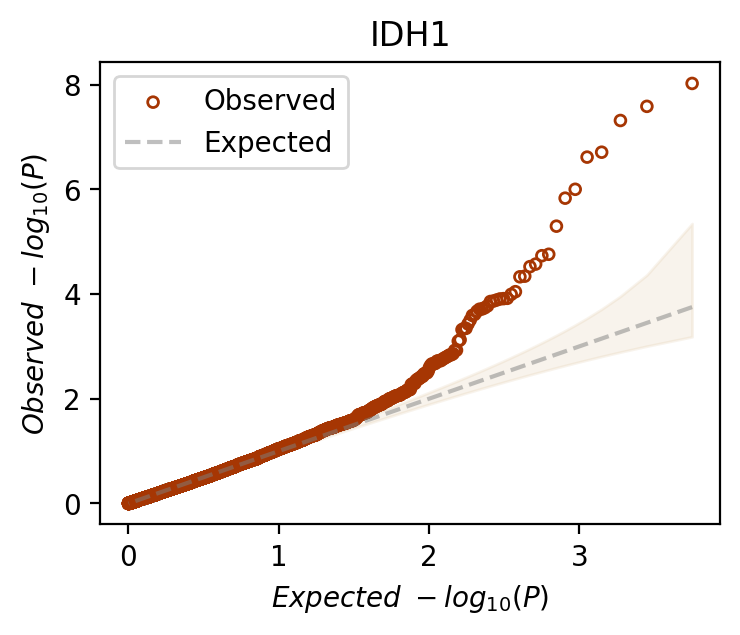

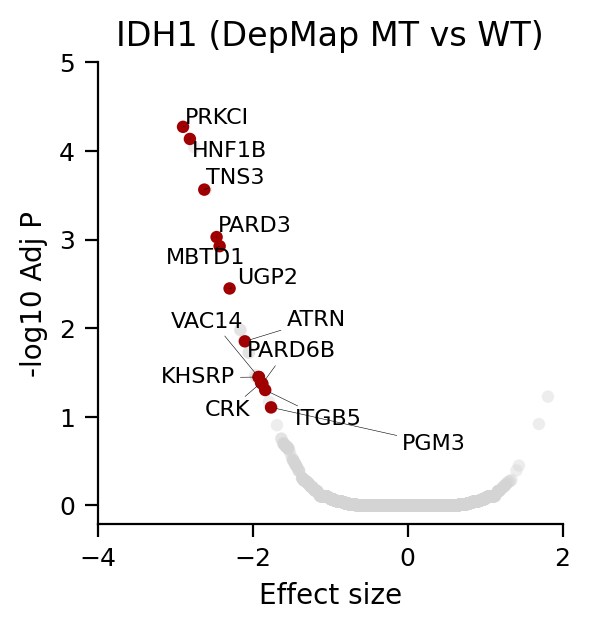


File  Figure2/output_fig2/IDH1_features_Down_(DepMap MT vs WT).csv saved, shape: (13, 5)


In [108]:
DifferentialDependency.select_differential_dependency(res_df, gene, in_group_col='in_group_gene_effect_mean', ylim_top=5, ytick_step=1, xtick_step=2, xlim_right=2, xlim_left=-4, force_points=1, force_text=1, save_figure=True, top_labels_cutoff=0, cut_off_texts=15, title='(DepMap MT vs WT)')#,